### visualize the lake height obtained by altimetry product.

In [ ]:
import re
import numpy as np
import xarray as xr
from glob import glob
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from utils.transform_time import dt64_to_dyr
from matplotlib.lines import Line2D


In [2]:
path_hma_gtng = 'data/hma-extent/HMA/hma_gtng_202307_subregions.gpkg'
path_dahiti_station = 'data/water-height/dahiti/dahiti_station_hma.gpkg'
path_hydroweb_station = 'data/water-height/hydroweb/hydroweb_stations_hma.gpkg'


In [3]:
dahiti_station = gpd.read_file(path_dahiti_station)
hydroweb_station = gpd.read_file(path_hydroweb_station)
hma_gtng = gpd.read_file(path_hma_gtng)
## remove the stations that are not in HMA lakes
dahiti_station = dahiti_station.dropna()
hydroweb_station = hydroweb_station.dropna()


In [4]:
# Find common Hylak_id values between dahiti_station and hydroweb_station
common_hylak_ids = set(dahiti_station['Hylak_id']).intersection(set(hydroweb_station['Hylak_id']))
print(f"Number of common Hylak_id: {len(common_hylak_ids)}")


Number of common Hylak_id: 47


#### show the time-series water level


In [25]:
## find the index of the common lake in dahiti and hydroweb.
hylak_id = list(common_hylak_ids)[34]
dahiti_id = dahiti_station[dahiti_station['Hylak_id'] == hylak_id]['dahiti_id'].values[0]
hydroweb_lake_name = hydroweb_station[hydroweb_station['Hylak_id'] == hylak_id]['name'].values[0]


#### dahiti:

In [26]:
dir_dahiti = 'data/water-height/dahiti'
paths_dahiti = glob(dir_dahiti + '/*.nc')
print(len(paths_dahiti))
paths_dahiti[0]


411


'data/water-height/dahiti/10782.nc'

In [27]:
# Find the path for the given dahiti_id
dahiti_path = [p for p in paths_dahiti if p.endswith(f"{dahiti_id}.nc")][0]
dahiti_dset = xr.open_dataset(dahiti_path)
date = dahiti_dset['datetime'][:]
dahiti_date_decimal = [dt64_to_dyr(dt) for dt in dahiti_dset['datetime'].values]
dahiti_wat_level = dahiti_dset['water_level'].values
dahiti_wat_level_error = dahiti_dset['error'].values


In [28]:
dahiti_dset


<xarray.Dataset> Size: 10kB
Dimensions:      (time: 116)
Dimensions without coordinates: time
Data variables:
    datetime     (time) <U19 9kB '2016-05-28 15:27:14' ... '2024-11-27 15:27:30'
    water_level  (time) float32 464B 4.741e+03 4.741e+03 ... 4.74e+03 4.739e+03
    error        (time) float32 464B 0.005 0.004 0.004 ... 0.002 0.016 0.001
Attributes: (12/13)
    dahiti_id:      41199
    dataset:        water-level-altimetry
    target_name:    Zonag, Lake
    location:       None
    country:        China
    continent:      Asia
    ...             ...
    latitude:       35.5482
    software:       8.0
    institution:    DGFI-TUM
    source:         DAHITI
    url:            https://dahiti.dgfi.tum.de/41199/
    creation_date:  2024-12-07 09:20:28

Text(0.5, 1.01, 'dahiti station: Zonag, Lake')

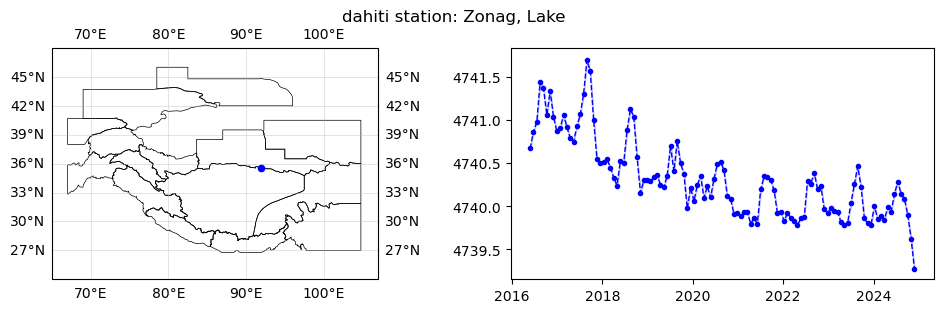

In [29]:
fig = plt.figure(figsize=(12,3))
ax1 = plt.subplot(1,2,1, projection=ccrs.PlateCarree())
ax1.set_extent([65.0, 107.0, 24.0, 46.0])
ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
hma_gtng.plot(ax=ax1, edgecolor='black', facecolor='none', linewidth=0.5)
ax1.scatter(dahiti_dset.longitude, dahiti_dset.latitude, color='blue', s=20, alpha=1, zorder=2)
### time-series water level
ax2 = fig.add_subplot(1,2,2)  ## no need to set projection
ax2.fill_between(dahiti_date_decimal, y1=dahiti_wat_level-dahiti_wat_level_error, 
                    y2=dahiti_wat_level+dahiti_wat_level_error, color='blue', alpha=0.2)
ax2.plot(dahiti_date_decimal, dahiti_wat_level, marker='o', linestyle='--', color='blue', linewidth=1, markersize=3)
fig.suptitle(f'dahiti station: {dahiti_dset.target_name}', fontsize=12, y=1.01)


#### hydroweb:

In [30]:
dir_hydroweb = 'data/water-height/hydroweb/hydroweb_lakes'
paths_hydroweb = glob(dir_hydroweb + '/*.txt')
print(len(paths_hydroweb))
paths_hydroweb[0]


57


'data/water-height/hydroweb/hydroweb_lakes/hydroprd_L_migriggyangzham.txt'

In [31]:
hydroweb_lake_path = [p for p in paths_hydroweb if hydroweb_lake_name in p][0]
print(hydroweb_lake_path)

data/water-height/hydroweb/hydroweb_lakes/hydroprd_L_zonag.txt


In [32]:
with open(hydroweb_lake_path, 'r') as f:
    content = f.read()
    # Extract decimal year and height using regular expressions
    pattern = re.compile(r'(\d+\.\d+)\s*;\s*\d{4}/\d{2}/\d{2}\s*;\s*\d{2}:\d{2}\s*;\s*([\d\.]+)\s*;\s*([\d\.]+)')
    matches = pattern.findall(content)
    # Convert matches to lists of floats
    hydroweb_decimal_years = [float(match[0]) for match in matches]
    hydroweb_heights = [float(match[1]) for match in matches]
    hydroweb_height_std = [float(match[2]) for match in matches]
    # Extract longitude and latitude from the content
    lon_match = re.search(r'lon=([\d\.]+)', content)
    lat_match = re.search(r'lat=([\d\.]+)', content)
    hydroweb_loc = (float(lon_match.group(1)), float(lat_match.group(1)))


Text(0.5, 1.01, 'hydroweb station: zonag')

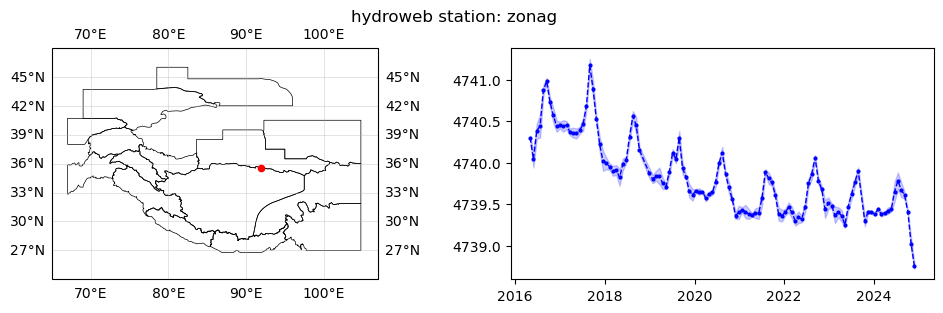

In [33]:
fig = plt.figure(figsize=(12,3))
### location of the station
ax1 = fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
ax1.set_extent([65.0, 107.0, 24.0, 46.0])
ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
hma_gtng.plot(ax=ax1, edgecolor='black', facecolor='none', linewidth=0.5)
ax1.scatter(hydroweb_loc[0], hydroweb_loc[1], color='red', s=20, alpha=1, zorder=2)
### time-series water level
ax2 = fig.add_subplot(1,2,2)
ax2.fill_between(hydroweb_decimal_years, y1=np.array(hydroweb_heights)-np.array(hydroweb_height_std), 
                    y2=np.array(hydroweb_heights)+np.array(hydroweb_height_std), color='blue', alpha=0.2)
ax2.plot(hydroweb_decimal_years, hydroweb_heights, marker='o', linestyle='--', color='blue', 
                    linewidth=1, markersize=2)
fig.suptitle(f'hydroweb station: {hydroweb_lake_name}', fontsize=12, y=1.01)


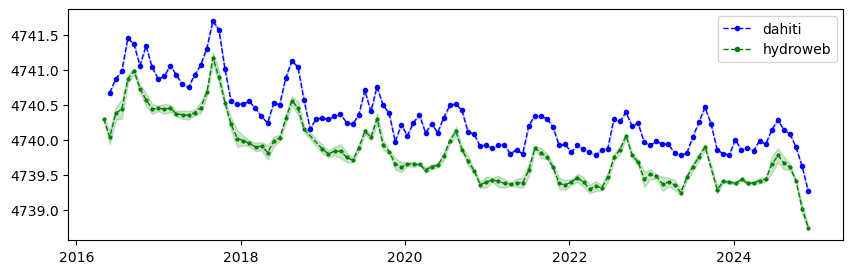

In [34]:

## show in the some axes
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
## dahiti
ax.fill_between(dahiti_date_decimal, y1=dahiti_wat_level-dahiti_wat_level_error, 
                    y2=dahiti_wat_level+dahiti_wat_level_error, color='blue', alpha=0.2)
ax.plot(dahiti_date_decimal, dahiti_wat_level, marker='o', linestyle='--', color='blue', linewidth=1, markersize=3)
## hydroweb
ax.fill_between(hydroweb_decimal_years, y1=np.array(hydroweb_heights)-np.array(hydroweb_height_std), 
                    y2=np.array(hydroweb_heights)+np.array(hydroweb_height_std), color='green', alpha=0.2)
ax.plot(hydroweb_decimal_years, hydroweb_heights, marker='o', linestyle='--', color='green', 
                    linewidth=1, markersize=2)

custom_lines = [
  Line2D([0], [0], color='blue', linestyle='--', marker='o', linewidth=1, markersize=3),
  Line2D([0], [0], color='green', linestyle='--', marker='o', linewidth=1, markersize=3)
]
ax.legend(custom_lines, ['dahiti', 'hydroweb'])
